In [382]:
import os
import torch
import pandas as pd
import math
import skimage
import random
from PIL import Image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.dom.minidom as xmldom

In [393]:
class Ldk_300W_Dataset(Dataset):
    def __init__(self, xmlfile, root_dir, transform=None):
        document = xmldom.parse(xmlfile)
        annos = document.getElementsByTagName("image")
        self.records = []
        for anno in annos:
            parts = anno.getElementsByTagName("part")
            landmark = []
            for part in parts:
                landmark.append(part.getAttribute("x"))
                landmark.append(part.getAttribute("y"))
            record = [anno.getAttribute("file"), landmark]
            self.records.append(record)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.records[idx][0])
        image = io.imread(img_name)
        image = np.float64(image)/256
        landmarks = map(float, self.records[idx][1])
        landmarks = np.asarray(landmarks).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def show(self,idx):
        record = self[idx]
        plt.scatter(record['landmarks'][:,0], record['landmarks'][:,1], s=10, marker='.', c='r')
        plt.imshow(record['image'])
#transform
class CropByLDK(object):
    def __init__(self, scale):
        assert isinstance(scale, float)
        if isinstance(scale, float):
            self.scale = scale
        else:
            self.scale = 0.2
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        left, right = landmarks[:,0].min(), landmarks[:,0].max()
        top, bottom = landmarks[:,1].min(), landmarks[:,1].max()
        height, width = bottom - top, right - left
        l = max(height, width) * self.scale
        middle = [left/2 + right/2, top/2 + bottom/2]
        left, right = int(middle[0] - l/2), int(middle[0] + l/2)
        top, bottom = int(middle[1] - l/2), int(middle[1] + l/2)
        image = image[top:bottom, left:right]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks':landmarks}
    
class Rescale(object):
    def __init__(self, size):
        assert isinstance(size, tuple)
        self.size = size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if len(image.shape) == 2:
            image = image.reshape(h, w, 1)
            image = np.concatenate((image,image,image),axis=2) 
        image = transform.resize(image, (self.size[0], self.size[1]))
        landmarks = landmarks * [self.size[0], self.size[1]] / [w, h]
        return {'image': image, 'landmarks':landmarks}
    
class Rotate(object):
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = transform.rotate(image, self.angle)
        left, right = min(landmarks[:,0]), max(landmarks[:,0])
        top, bottom = min(landmarks[:,1]), max(landmarks[:,1])
        angle = math.radians(-self.angle)
        rotate_matrix = [[math.cos(angle), -math.sin(angle)]
                          ,[math.sin(angle), math.cos(angle)]]
        middle = [left/2 + right/2, top/2 + bottom/2]
        landmarks_r = (landmarks - middle).transpose((1,0))
        landmarks_r = np.matmul(rotate_matrix, landmarks_r)
        landmarks_r = landmarks_r.transpose((1,0))
        landmarks = landmarks_r + middle
        
        return {'image': image, 'landmarks': landmarks}
    
class Flip(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        image = Image.fromarray(np.uint8(image * 256))
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        image = np.asarray(image)
        image = np.float64(image)/256
        landmarks[:, 0] = w - landmarks[:, 0]
        return {'image' : image, 'landmarks': landmarks}

class RandomCrop(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        r = image.shape[0]
        size = r * random.uniform(0.9, 1.0)
        print r, size
        x0 = random.randint(0, r - 1)
        y0 = random.randint(0, r - 1)
        x1 = x0 + int(size)
        y1 = y0 + int(size)
        image = image[y0:y1, x0:x1]
        landmarks = landmarks - [x0, y0]
        return {'image' : image, 'landmarks': landmarks}
        
class Gnoise(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = skimage.util.random_noise(image,mode='gaussian',seed=None,clip=True)
        return {'image': image, 'landmarks': landmarks}
    
class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

In [397]:
path_300w = '/home/whale/dataset/Landmark/300W'
path_train = os.path.join(path_300w, "train.xml")
path_test = os.path.join(path_300w, "test.xml")
path_all = os.path.join(path_300w, "all.xml")
composed = transforms.Compose([CropByLDK(1.4), Flip(), Rotate(30), Gnoise(), RandomCrop(), Rescale((64,64)), ToTensor()])
#inall = Ldk_300W_Dataset(path_all,path_300w)
#train = Ldk_300W_Dataset(path_train, path_300w)
test = Ldk_300W_Dataset(path_test, path_300w, composed)

In [398]:
dataloader = DataLoader(test, batch_size=4, shuffle=True, num_workers=4)

310 291.868896873


/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


963 874.22297815


/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


266 264.362369908
442 417.762058638
1342 1328.12360566
252 236.489319891
186 179.887954725
250 229.99996759
1472 1426.40537943


/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(0, torch.Size([4, 3, 64, 64]), torch.Size([4, 68, 2]))
478 474.061002965


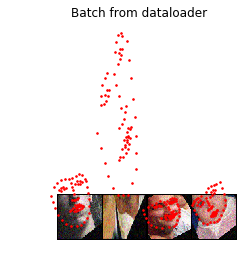

/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1579 1567.11598992


/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/whale/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


144 129.868827603
178 162.964268651
165 157.944060328
530 509.217313838
297 288.77609929
864 785.533114585
1100 1061.79626224
403 386.463116011
1893 1748.41046454
385 382.394780435


In [399]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * (im_size+2),
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break